<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/ord2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install tf-nightly-2.0-preview

    100% |████████████████████████████████| 86.8MB 284kB/s 
    100% |████████████████████████████████| 3.1MB 11.1MB/s 
    100% |████████████████████████████████| 61kB 21.7MB/s 
    100% |████████████████████████████████| 430kB 20.3MB/s 
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


In [0]:
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
%matplotlib inline

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu

In [337]:
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-dev20190420


In [0]:
nx = 10
dx = 1. / nx

In [0]:
def f(x, psy, dpsy):
    '''
        d2(psy)/dx2 = f(x, dpsy/dx, psy)
        This is f() function on the right
    '''
    return -1./5. * np.exp(-x/5.) * np.cos(x) - 1./5. * dpsy - psy


def psy_analytic(x):
    '''
        Analytical solution of current problem
    '''
    return np.exp(-x/5.) * np.sin(x)

def psy_trial(xi, net_out):
    return xi + xi**2 * net_out

# Build Neural Network

In [0]:
def loss_function(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)

In [0]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1,  activation='tanh'))
optimizer = tf.keras.optimizers.Adam()

In [0]:
x_space = np.linspace(0, 2, 10).astype('float64').reshape(10,1)
x_space = tf.constant(x_space)

In [0]:
def train_on_batch(x):
    with tf.GradientTape() as g:
        g.watch(x)
        with tf.GradientTape() as gg:
            gg.watch(x)
            net_out = model(x)
            psy_t = psy_trial(x, net_out)

        dy_dx = gg.gradient(psy_t, x)     # gradient
    d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient

    with tf.GradientTape() as g_total:
        g_total.watch(x)
        net_out = model(x)
        psy_t = psy_trial(x, net_out)
        func = f(x, psy_t, dy_dx) # right part function
        loss = loss_function(d2y_dx2, func)
        
    grads = g_total.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    
    return tf.math.reduce_sum(loss)

In [413]:
for i in range(1000):
    loss = train_on_batch(x_space)
    if i % 200 == 0:
        print(loss)

tf.Tensor(65.73309163502974, shape=(), dtype=float64)
tf.Tensor(0.5750616642745463, shape=(), dtype=float64)
tf.Tensor(0.08569718783575456, shape=(), dtype=float64)
tf.Tensor(0.019298895367919042, shape=(), dtype=float64)
tf.Tensor(0.2901788171353029, shape=(), dtype=float64)


In [0]:
y_space = psy_analytic(x_space)

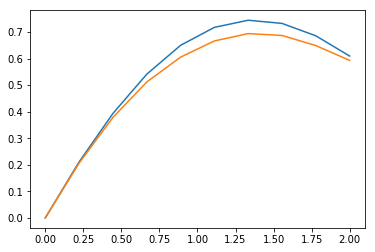

In [415]:
plt.figure()
res = [xi + xi**2 * model(np.array(xi).reshape(1,1))[0][0] for xi in x_space] 
plt.plot(x_space, y_space) 
plt.plot(x_space, res)
plt.show()